# FanSight End-to-End Workbook
Interactive walkthrough covering data collection, processing, EDA, clustering, modeling, and dashboarding.

import os, sys, pathlib, pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)

PROJECT_ROOT = pathlib.Path(__file__).resolve().parents[1]
RAW_DIR = PROJECT_ROOT / 'data' / 'raw'
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project root:', PROJECT_ROOT)
print('Working dir:', pathlib.Path.cwd())
print('Raw dir:', RAW_DIR)
print('Processed dir:', PROCESSED_DIR)
print('Python version:', sys.version)


In [1]:
import os, sys, pathlib, pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)

PROJECT_ROOT = pathlib.Path.cwd().resolve()
if not (PROJECT_ROOT / 'fansight').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
RAW_DIR = PROJECT_ROOT / 'data' / 'raw'
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project root:', PROJECT_ROOT)
print('Raw dir:', RAW_DIR)
print('Processed dir:', PROCESSED_DIR)
print('Python version:', sys.version)


Project root: /Users/karan/Desktop/Learnings/fansight_project
Raw dir: /Users/karan/Desktop/Learnings/fansight_project/data/raw
Processed dir: /Users/karan/Desktop/Learnings/fansight_project/data/processed
Python version: 3.12.8 (v3.12.8:2dc476bcb91, Dec  3 2024, 14:43:19) [Clang 13.0.0 (clang-1300.0.29.30)]


## 1. (Optional) Refresh Raw Datasets

In [ ]:
import subprocess
RUN_FETCH = False
if RUN_FETCH:
    subprocess.run(['python', '-m', 'fansight.scripts.fetch_nba_games', '--start', '2018', '--end', '2025'], check=True)
    subprocess.run(['python', '-m', 'fansight.scripts.fetch_bref_attendance', '--start', '2019', '--end', '2025'], check=True)


## 2. Build the processed games.csv

In [2]:
from fansight.scripts.build_games_dataset import build_dataset

games_df = build_dataset()
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
GAMES_PATH = PROCESSED_DIR / 'games.csv'
games_df.to_csv(GAMES_PATH, index=False)
print(f'Saved {len(games_df):,} rows to {GAMES_PATH}')


Saved 7,640 rows to /Users/karan/Desktop/Learnings/fansight_project/data/processed/games.csv


## 3. Data overview

### Column Guide
- `game_id`: Unique NBA game identifier.
- `game_date`: Calendar date of the game.
- `home_team`: Home franchise name.
- `visitor_team`: Visiting franchise name.
- `season_id`: Numeric season code from NBA stats.
- `season`: Human-readable season string (e.g., 2018-19).
- `team_id`: Internal NBA team ID for the home franchise.
- `team_abbreviation`: Home team abbreviation (e.g., BOS).
- `team_name`: Redundant home team name from NBA stats.
- `result`: `W` if home team won, `L` otherwise.
- `fgm`: Home team field goals made.
- `fga`: Home team field goals attempted.
- `fg_pct`: Field-goal percentage.
- `fg3m`: Three-pointers made.
- `fg3a`: Three-pointers attempted.
- `fg3_pct`: Three-point percentage.
- `ftm`: Free throws made.
- `fta`: Free throws attempted.
- `ft_pct`: Free-throw percentage.
- `oreb`: Offensive rebounds.
- `dreb`: Defensive rebounds.
- `reb`: Total rebounds.
- `ast`: Assists.
- `stl`: Steals.
- `blk`: Blocks.
- `tov`: Turnovers.
- `pf`: Personal fouls.
- `home_pts`: Points scored by the home team.
- `plus_minus`: Scoring margin for the home team.
- `win_pct_home`: Rolling win percentage for the home team entering the game.
- `win_pct_visitor`: Rolling win percentage for the visitor entering the game.
- `attendance`: Reported attendance for the game.
- `arena`: Venue name.
- `notes`: Miscellaneous game notes from Basketball-Reference.
- `source_file`: Source spreadsheet used for attendance data.
- `capacity`: Arena seating capacity lookup.
- `ticket_price`: Placeholder average ticket price (USD).

In [3]:
games_df.head()

,game_id,game_date,home_team,visitor_team,season_id,season,team_id,team_abbreviation,team_name,result,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,home_pts,plus_minus,win_pct_home,win_pct_visitor,attendance,arena,notes,source_file,capacity,ticket_price
0,21800001,2018-10-16,Boston Celtics,Philadelphia 76ers,22018,2018-19,1610612738,BOS,Boston Celtics,W,42,97,0.433,11,37,0.297,10,14,0.714,12,43,55,21,7,5,15,20,105,18,<NA>,<NA>,18624,TD Garden,NaN,sportsref_download (8).xls,18624,120.0
1,21800002,2018-10-16,Golden State Warriors,Oklahoma City Thunder,22018,2018-19,1610612744,GSW,Golden State Warriors,W,42,95,0.442,7,26,0.269,17,18,0.944,17,41,58,28,7,7,21,29,108,8,<NA>,<NA>,19596,Oracle Arena,NaN,sportsref_download (8).xls,18064,150.0
2,21800009,2018-10-17,Houston Rockets,New Orleans Pelicans,22018,2018-19,1610612745,HOU,Houston Rockets,L,39,92,0.424,16,48,0.333,18,24,0.750,8,29,37,21,8,7,12,22,112,-19,<NA>,<NA>,18055,Toyota Center,NaN,sportsref_download (8).xls,18055,100.0
3,21800007,2018-10-17,New York Knicks,Atlanta Hawks,22018,2018-19,1610612752,NYK,New York Knicks,W,45,99,0.455,12,33,0.364,24,31,0.774,10,36,46,21,12,6,16,23,126,19,<NA>,<NA>,18249,Madison Square Garden (IV),NaN,sportsref_download (8).xls,19763,160.0
4,21800006,2018-10-17,Orlando Magic,Miami Heat,22018,2018-19,1610612753,ORL,Orlando Magic,W,39,94,0.415,7,25,0.280,19,31,0.613,14,37,51,20,7,7,12,25,104,3,<NA>,<NA>,19191,Amway Center,NaN,sportsref_download (8).xls,18846,100.0


In [4]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7640 entries, 0 to 7639
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   game_id            7640 non-null   int64         
 1   game_date          7640 non-null   datetime64[ns]
 2   home_team          7640 non-null   object        
 3   visitor_team       7640 non-null   object        
 4   season_id          7640 non-null   int64         
 5   season             7640 non-null   object        
 6   team_id            7640 non-null   int64         
 7   team_abbreviation  7640 non-null   object        
 8   team_name          7640 non-null   object        
 9   result             7640 non-null   object        
 10  fgm                7640 non-null   int64         
 11  fga                7640 non-null   int64         
 12  fg_pct             7640 non-null   float64       
 13  fg3m               7640 non-null   int64         
 14  fg3a    

In [4]:
summary = games_df.describe(include='all').transpose()
summary[['count','mean','std','min','25%','50%','75%','max']]

,count,mean,std,min,25%,50%,75%,max
game_id,7640.0,22108561.487304,201288.245306,21800001.0,21900818.5,22100822.5,22300408.25,22401228.0
game_date,7640,2022-02-17 15:11:52.460732928,NaN,2018-10-16 00:00:00,2020-02-12 18:00:00,2022-02-09 00:00:00,2023-12-21 00:00:00,2025-04-13 00:00:00
home_team,7640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visitor_team,7640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season_id,7640.0,22021.079712,2.012673,22018.0,22019.0,22021.0,22023.0,22024.0
season,7640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
team_id,7640.0,1610612751.675654,8.752314,1610612737.0,1610612744.0,1610612752.0,1610612759.0,1610612766.0
team_abbreviation,7640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
team_name,7640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
result,7640,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
numeric_cols = games_df.select_dtypes(include=['number']).columns
games_df[numeric_cols].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
game_id,7640.0,22108561.487304,201288.245306,21800001.0,21900818.5,22100822.5,22300408.25,22401228.0
season_id,7640.0,22021.079712,2.012673,22018.0,22019.0,22021.0,22023.0,22024.0
team_id,7640.0,1610612751.675654,8.752314,1610612737.0,1610612744.0,1610612752.0,1610612759.0,1610612766.0
fgm,7640.0,41.711126,5.242583,21.0,38.0,42.0,45.0,65.0
fga,7640.0,88.7,7.158194,64.0,84.0,88.0,93.0,123.0
fg_pct,7640.0,0.471274,0.054923,0.269,0.433,0.47,0.507,0.689
fg3m,7640.0,12.663482,3.942541,2.0,10.0,12.0,15.0,29.0
fg3a,7640.0,34.901047,7.153152,11.0,30.0,35.0,40.0,70.0
fg3_pct,7640.0,0.362203,0.083914,0.069,0.306,0.361,0.417,0.842
ftm,7640.0,17.568063,5.966795,1.0,13.0,17.0,21.0,44.0


In [5]:
categorical_cols = games_df.select_dtypes(exclude=['number']).columns
games_df[categorical_cols].nunique().sort_values(ascending=False)

win_pct_visitor      1218
win_pct_home         1210
game_date            1093
arena                  52
source_file            49
home_team              29
visitor_team           29
team_abbreviation      29
team_name              29
season                  7
notes                   5
result                  2
dtype: int64

In [8]:
cat_summary = pd.DataFrame({
    'non_null': games_df[categorical_cols].count(),
    'unique': games_df[categorical_cols].nunique(),
    'missing': len(games_df) - games_df[categorical_cols].count()
})
cat_summary.sort_values('unique', ascending=False)


,non_null,unique,missing
win_pct_visitor,7541,1218,99
win_pct_home,7542,1210,98
game_date,7640,1093,0
arena,7640,52,0
source_file,7640,49,0
home_team,7640,29,0
visitor_team,7640,29,0
team_abbreviation,7640,29,0
team_name,7640,29,0
season,7640,7,0


In [6]:
missing_counts = games_df.isna().sum()
missing_pct = (missing_counts / len(games_df)).sort_values(ascending=False)
missing_summary = pd.DataFrame({'missing_count': missing_counts, 'missing_pct': missing_pct})
missing_summary[missing_summary['missing_count'] > 0]


,missing_count,missing_pct
notes,7510,0.982984
win_pct_home,98,0.012827
win_pct_visitor,99,0.012958


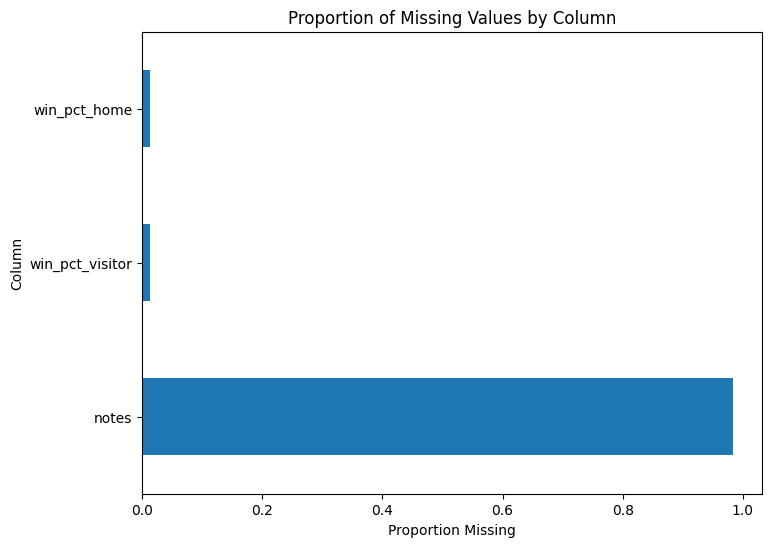

In [7]:
missing = games_df.isna().mean().sort_values(ascending=False)
missing[missing > 0.0].plot.barh(figsize=(8,6), title='Proportion of Missing Values by Column')
plt.xlabel('Proportion Missing')
plt.ylabel('Column')
plt.show()

### Attendance distribution

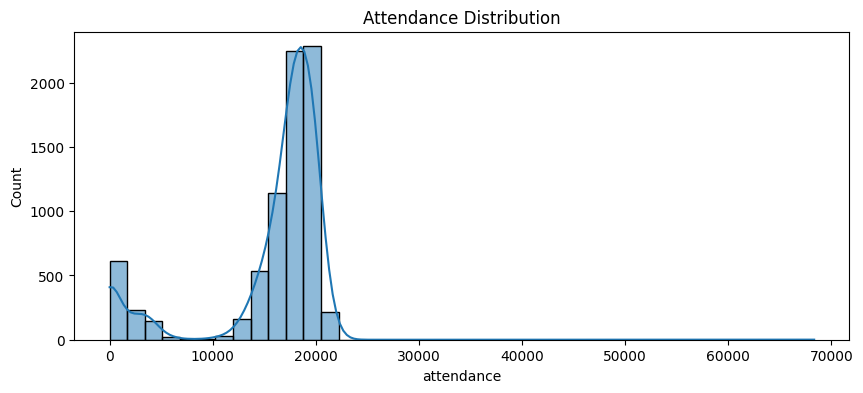

In [8]:
plt.figure(figsize=(10,4))
sns.histplot(games_df['attendance'], bins=40, kde=True)
plt.title('Attendance Distribution')
plt.show()


### Attendance by year

In [9]:
games_df['season_year'] = pd.to_datetime(games_df['game_date']).dt.year
fig = px.box(games_df, x='season_year', y='attendance', title='Attendance by Year')
fig.show()

### Attendance by Home Team
Compare average attendance for the most frequent home teams.

In [10]:
top_teams = games_df['home_team'].value_counts().index
team_avg = (games_df[games_df['home_team'].isin(top_teams)]
            .groupby('home_team')['attendance']
            .mean()
            .sort_values(ascending=False))
fig = px.bar(team_avg, title='Average Attendance by Top Home Teams', labels={'value':'Average attendance','index':'Home team'})
fig.show()


### Attendance by Day of Week
See whether weekend games draw more crowds.

In [11]:
games_df['day_of_week'] = pd.to_datetime(games_df['game_date']).dt.day_name()
weekday_summary = games_df.groupby('day_of_week')['attendance'].agg(['count','mean']).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
weekday_summary


,count,mean
day_of_week,,
Monday,1137,15444.598945
Tuesday,821,15542.514007
Wednesday,1455,15514.914777
Thursday,730,15430.108219
Friday,1367,16090.286028
Saturday,1087,16126.111316
Sunday,1043,15752.730585


In [12]:
fig = px.box(games_df, x='day_of_week', y='attendance', category_orders={'day_of_week':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']}, title='Attendance by Day of Week')
fig.show()


### Capacity vs attendance

In [13]:
fig = px.scatter(games_df, x='capacity', y='attendance', hover_data=['home_team','visitor_team','game_date'])
fig.update_layout(title='Capacity vs Attendance')
fig.show()


### Rolling trend by team

In [14]:
team = 'Boston Celtics'
team_df = games_df[games_df['home_team']==team].sort_values('game_date')
team_df['attendance_roll'] = team_df['attendance'].rolling(5, min_periods=1).mean()
fig = go.Figure()
fig.add_trace(go.Scatter(x=team_df['game_date'], y=team_df['attendance'], mode='lines+markers', name='actual'))
fig.add_trace(go.Scatter(x=team_df['game_date'], y=team_df['attendance_roll'], mode='lines', name='5-game avg'))
fig.update_layout(title=f'{team} Attendance Trend', xaxis_title='Game Date', yaxis_title='Attendance')
fig.show()


## 4. Correlations

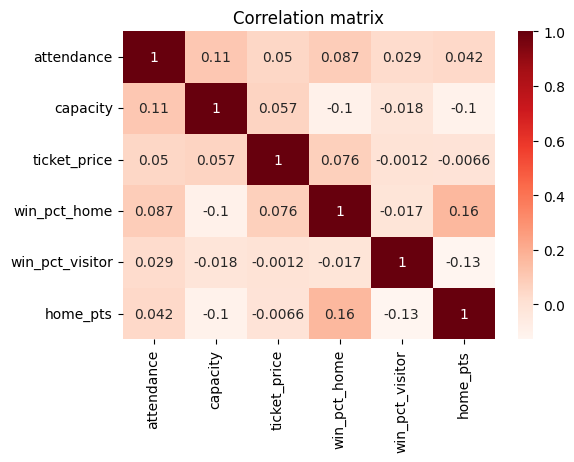

In [15]:
numeric_cols = ['attendance','capacity','ticket_price','win_pct_home','win_pct_visitor','home_pts']
subset = games_df[numeric_cols].dropna()
plt.figure(figsize=(6,4))
sns.heatmap(subset.corr(), annot=True, cmap='Reds')
plt.title('Correlation matrix')
plt.show()

## 5. Clustering snapshot

In [16]:
# from fansight.features.segmentation import run_kmeans_segmentation

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
cluster_cols = ['attendance','capacity','ticket_price','win_pct_home','win_pct_visitor']
cluster_input = games_df.dropna(subset=cluster_cols).copy()

scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_input[cluster_cols])

kmeans = KMeans(n_clusters=5, random_state=18, n_init='auto')
cluster_input['segment'] = kmeans.fit_predict(scaled)
cluster_input.groupby('segment')[cluster_cols].mean()


,attendance,capacity,ticket_price,win_pct_home,win_pct_visitor
segment,,,,,
0,17029.745844,17728.158793,101.277340,0.508564,0.57378
1,17732.616515,18852.011896,101.522043,0.507942,0.264074
2,17139.974497,18970.216107,150.550336,0.51305,0.502916
3,18668.020465,19833.834884,100.258140,0.468883,0.578074
4,1404.916936,18791.906149,102.351672,0.489114,0.49393


In [17]:
fig = px.scatter(cluster_input, x='win_pct_home', y='attendance', color='segment', hover_data=['home_team','game_date'])
fig.update_layout(title='Segments by win pct vs attendance')
fig.show()


### Key EDA Observations

- Attendance distribution clusters tightly around 18–19k (most arenas operate near capacity) with a long tail of zeros in 2020–21 (pandemic restrictions) and a rare 70k outlier (special venue).

- Attendance by year confirms 2021 is the COVID season: median attendance collapses to ~0, then rebounds.
- Day-of-week and home-team analyses show fairly consistent medians, but some teams (76ers, Bulls, Knicks, etc.) draw slightly more on average.
- Capacity vs attendance reveals that raw capacity doesn’t correlate strongly (Pearson ~0.11) because venue capacity is almost constant per team; demand is better captured by sell-through (attendance / capacity).
- Correlation heatmap highlights weak linear links among the selected metrics, suggesting we should derive better features (sell-through, COVID flag, etc.) rather than relying on raw capacity or ticket_price alone.
- Clustering cleanly separates pandemic games (segment with ~1.4k attendance) from normal games and exposes a “premium” segment (high ticket_price and high attendance). Those cluster IDs can become useful flags.

## Feature Engineering

- Feature selection / pruning

    - Drop fields you won’t know before the game (post-game stats like FGM/FGA if you’re forecasting pre-game attendance).
    - Remove redundant columns identified during EDA (e.g., keep fg_pct or fgm/fga, not all).
    - Keep only the fields that pass the “available before kickoff” test plus engineered features you’ll add.

- Outlier handling

    - Clip or tag special events (attendance >> capacity) and pandemic zeros. Decide whether to exclude them or keep with a flag.
    - You can filter by attendance < 0.2 * capacity (pandemic) and attendance > 1.2 * capacity (special events), then either drop or mark with binary features.

- COVID / regime flags

    - Instead of outright removing those rows, you can add features like covid_restriction (1 if attendance < threshold or between certain dates) so the model can learn regime differences.
    - If your forecast should ignore pandemic behavior, then drop those rows up front.

- New engineered features

    - Sell-through rate (attendance / capacity) or use it as the primary target instead of raw attendance.
    - Day-of-week, month, holiday indicators.
    - Rolling stats: recent average attendance, home win streak, visitor win percentage, etc.
    - Clustering segment ID if that captures useful regimes.

- Encoding

    - One-hot encode (or use target encoding) for categorical variables like home_team, visitor_team, arena.
    - Encode binary flags (covid, special event, rivalry, promo) as 0/1.

- Scaling (if needed)

    - For algorithms sensitive to scale (KMeans, neural nets), standardize numeric features. Tree-based models don’t require it.

- Train/test split

    - Do a time-based split (e.g., train on 2018–2023, validate/test on 2024+) to respect chronology. Apply all preprocessing steps inside a pipeline so there’s no leakage.


### Drop unwanted columns

In [18]:
drop_cols = [
    'season_id', 'team_id', 'team_abbreviation', 'team_name',
    'result', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct',
    'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
    'tov', 'pf', 'home_pts', 'plus_minus', 'season',
    'notes', 'source_file'
    ]

cleaned_df = games_df.drop(columns=drop_cols)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7640 entries, 0 to 7639
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   game_id          7640 non-null   int64         
 1   game_date        7640 non-null   datetime64[ns]
 2   home_team        7640 non-null   object        
 3   visitor_team     7640 non-null   object        
 4   win_pct_home     7542 non-null   object        
 5   win_pct_visitor  7541 non-null   object        
 6   attendance       7640 non-null   Int64         
 7   arena            7640 non-null   object        
 8   capacity         7640 non-null   Int64         
 9   ticket_price     7640 non-null   float64       
 10  season_year      7640 non-null   int32         
 11  day_of_week      7640 non-null   object        
dtypes: Int64(2), datetime64[ns](1), float64(1), int32(1), int64(1), object(6)
memory usage: 701.5+ KB


In [19]:
cleaned_df.head()

,game_id,game_date,home_team,visitor_team,win_pct_home,win_pct_visitor,attendance,arena,capacity,ticket_price,season_year,day_of_week
0,21800001,2018-10-16,Boston Celtics,Philadelphia 76ers,<NA>,<NA>,18624,TD Garden,18624,120.0,2018,Tuesday
1,21800002,2018-10-16,Golden State Warriors,Oklahoma City Thunder,<NA>,<NA>,19596,Oracle Arena,18064,150.0,2018,Tuesday
2,21800009,2018-10-17,Houston Rockets,New Orleans Pelicans,<NA>,<NA>,18055,Toyota Center,18055,100.0,2018,Wednesday
3,21800007,2018-10-17,New York Knicks,Atlanta Hawks,<NA>,<NA>,18249,Madison Square Garden (IV),19763,160.0,2018,Wednesday
4,21800006,2018-10-17,Orlando Magic,Miami Heat,<NA>,<NA>,19191,Amway Center,18846,100.0,2018,Wednesday


### Handle Missing Values

In [20]:
cleaned_df['win_pct_home'] = cleaned_df['win_pct_home'].fillna(cleaned_df['win_pct_home'].mean())
cleaned_df['win_pct_visitor'] = cleaned_df['win_pct_visitor'].fillna(cleaned_df['win_pct_visitor'].mean())

In [21]:
cleaned_df['win_pct_home'].info(), cleaned_df['win_pct_visitor'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7640 entries, 0 to 7639
Series name: win_pct_home
Non-Null Count  Dtype  
--------------  -----  
7640 non-null   float64
dtypes: float64(1)
memory usage: 59.8 KB
<class 'pandas.core.series.Series'>
RangeIndex: 7640 entries, 0 to 7639
Series name: win_pct_visitor
Non-Null Count  Dtype  
--------------  -----  
7640 non-null   float64
dtypes: float64(1)
memory usage: 59.8 KB


(None, None)

### Converting numeric columns to appropriate types

For columns win_pct_home, win_pct_visitor convert to float type.

In [22]:
cleaned_df['win_pct_home'].dtype, cleaned_df['win_pct_visitor'].dtype

(dtype('float64'), dtype('float64'))

In [23]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7640 entries, 0 to 7639
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   game_id          7640 non-null   int64         
 1   game_date        7640 non-null   datetime64[ns]
 2   home_team        7640 non-null   object        
 3   visitor_team     7640 non-null   object        
 4   win_pct_home     7640 non-null   float64       
 5   win_pct_visitor  7640 non-null   float64       
 6   attendance       7640 non-null   Int64         
 7   arena            7640 non-null   object        
 8   capacity         7640 non-null   Int64         
 9   ticket_price     7640 non-null   float64       
 10  season_year      7640 non-null   int32         
 11  day_of_week      7640 non-null   object        
dtypes: Int64(2), datetime64[ns](1), float64(3), int32(1), int64(1), object(4)
memory usage: 701.5+ KB


### Flag games heavily restricted by COVID (attendance < 20% of capacity or 2020-2021 seasons)

In [24]:
covid_flag = ((cleaned_df['attendance'] < 0.2 * cleaned_df['capacity']) |
              (cleaned_df['game_date'].between('2020-03-01', '2021-10-31')))

cleaned_df['covid_restricted'] = covid_flag # Bool

### Feature Transformations

In [25]:
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

transformed_df = cleaned_df.copy()

# 1. Sell through rate
transformed_df['sell_through_rate'] = transformed_df['attendance'] / transformed_df['capacity']

# 2. Is holiday game
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=transformed_df['game_date'].min(), end=transformed_df['game_date'].max())
transformed_df['is_holiday'] = transformed_df['game_date'].isin(holidays)

# 3. Rolling average attendance based on last 5 home games, win percentage of home team, win percentage of visitor team, and ticket sell through rate
transformed_df = transformed_df.sort_values(['home_team', 'game_date'])
transformed_df['rolling_avg_attendance'] = (transformed_df
                                            .groupby('home_team')['attendance']
                                            .transform(lambda x: x.rolling(window=5, min_periods=1).mean()))
transformed_df['rolling_avg_win_pct_home'] = (transformed_df
                                             .groupby('home_team')['win_pct_home']
                                             .transform(lambda x: x.rolling(window=5, min_periods=1).mean()))
transformed_df['rolling_avg_win_pct_visitor'] = (transformed_df
                                                .groupby('visitor_team')['win_pct_visitor']
                                                .transform(lambda x: x.rolling(window=5, min_periods=1).mean()))
transformed_df['rolling_avg_sell_through'] = (transformed_df
                                             .groupby('home_team')['sell_through_rate']
                                             .transform(lambda x: x.rolling(window=5, min_periods=1).mean()))

# 4. KMeans clustering based on attendance, capacity, ticket price, win percentages home and visitor teams
cluster_features = ['attendance', 'capacity', 'ticket_price', 'win_pct_home', 'win_pct_visitor']
X = transformed_df[cluster_features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
transformed_df['cluster'] = kmeans.fit_predict(X_scaled)

transformed_df.head()

/Users/karan/Desktop/Learnings/fansight_project/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,game_id,game_date,home_team,visitor_team,win_pct_home,win_pct_visitor,attendance,arena,capacity,ticket_price,season_year,day_of_week,covid_restricted,sell_through_rate,is_holiday,rolling_avg_attendance,rolling_avg_win_pct_home,rolling_avg_win_pct_visitor,rolling_avg_sell_through,cluster
48,21800052,2018-10-24,Atlanta Hawks,Dallas Mavericks,0.333333,0.666667,16705,State Farm Arena,16600,100.0,2018,Wednesday,False,1.006325,False,16705.0,0.333333,0.666667,1.006325,0
68,21800076,2018-10-27,Atlanta Hawks,Chicago Bulls,0.500000,0.200000,15549,State Farm Arena,16600,100.0,2018,Saturday,False,0.936687,False,16127.0,0.416667,0.200000,0.971506,1
107,21800114,2018-11-01,Atlanta Hawks,Sacramento Kings,0.285714,0.625000,12095,State Farm Arena,16600,100.0,2018,Thursday,False,0.728614,False,14783.0,0.373016,0.625000,0.890542,0
115,21800128,2018-11-03,Atlanta Hawks,Miami Heat,0.250000,0.428571,16303,State Farm Arena,16600,100.0,2018,Saturday,False,0.982108,False,15163.0,0.342262,0.428571,0.913434,0
144,21800155,2018-11-07,Atlanta Hawks,New York Knicks,0.300000,0.272727,12412,State Farm Arena,16600,100.0,2018,Wednesday,False,0.747711,False,14612.8,0.333810,0.272727,0.880289,0


In [26]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7640 entries, 48 to 7604
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   game_id                      7640 non-null   int64         
 1   game_date                    7640 non-null   datetime64[ns]
 2   home_team                    7640 non-null   object        
 3   visitor_team                 7640 non-null   object        
 4   win_pct_home                 7640 non-null   float64       
 5   win_pct_visitor              7640 non-null   float64       
 6   attendance                   7640 non-null   Int64         
 7   arena                        7640 non-null   object        
 8   capacity                     7640 non-null   Int64         
 9   ticket_price                 7640 non-null   float64       
 10  season_year                  7640 non-null   int32         
 11  day_of_week                  7640 non-null   ob

In [27]:
transformed_df = transformed_df.drop(columns=['arena'])

### One Hot Encoding using ColumnTransformer and OneHotEncoder

In [28]:
numeric_cols = ['win_pct_home','win_pct_visitor','attendance','capacity','ticket_price',
                'season_year','sell_through_rate','rolling_avg_attendance',
                'rolling_avg_win_pct_home','rolling_avg_win_pct_visitor',
                'rolling_avg_sell_through']

transformed_df[numeric_cols] = transformed_df[numeric_cols].apply(pd.to_numeric)
transformed_df[['covid_restricted','is_holiday']] = transformed_df[['covid_restricted','is_holiday']].astype(int)

In [29]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7640 entries, 48 to 7604
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   game_id                      7640 non-null   int64         
 1   game_date                    7640 non-null   datetime64[ns]
 2   home_team                    7640 non-null   object        
 3   visitor_team                 7640 non-null   object        
 4   win_pct_home                 7640 non-null   float64       
 5   win_pct_visitor              7640 non-null   float64       
 6   attendance                   7640 non-null   Int64         
 7   capacity                     7640 non-null   Int64         
 8   ticket_price                 7640 non-null   float64       
 9   season_year                  7640 non-null   int32         
 10  day_of_week                  7640 non-null   object        
 11  covid_restricted             7640 non-null   in

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

categorical_cols = ['home_team', 'visitor_team', 'day_of_week', 'covid_restricted', 'is_holiday', 'cluster']
numeric_cols = [col for col in transformed_df.columns
                if col not in categorical_cols + ['game_id', 'game_date']]

# Cast pandas nullable ints/bools to native types so sklearn doesn’t see an object dtype
numeric_data = transformed_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ],
    remainder='drop'
)

transformed_data = preprocessor.fit_transform(pd.concat([transformed_df[categorical_cols], numeric_data], axis=1))

cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([cat_features, numeric_cols])

transformed_df_ohe = pd.DataFrame(transformed_data.toarray(), columns=all_feature_names)
transformed_df_ohe.head()

,home_team_Atlanta Hawks,home_team_Boston Celtics,home_team_Brooklyn Nets,home_team_Charlotte Hornets,home_team_Chicago Bulls,home_team_Cleveland Cavaliers,home_team_Dallas Mavericks,home_team_Denver Nuggets,home_team_Detroit Pistons,home_team_Golden State Warriors,home_team_Houston Rockets,home_team_Indiana Pacers,home_team_Los Angeles Lakers,home_team_Memphis Grizzlies,home_team_Miami Heat,home_team_Milwaukee Bucks,home_team_Minnesota Timberwolves,home_team_New Orleans Pelicans,home_team_New York Knicks,home_team_Oklahoma City Thunder,home_team_Orlando Magic,home_team_Philadelphia 76ers,home_team_Phoenix Suns,home_team_Portland Trail Blazers,home_team_Sacramento Kings,home_team_San Antonio Spurs,home_team_Toronto Raptors,home_team_Utah Jazz,home_team_Washington Wizards,visitor_team_Atlanta Hawks,visitor_team_Boston Celtics,visitor_team_Brooklyn Nets,visitor_team_Charlotte Hornets,visitor_team_Chicago Bulls,visitor_team_Cleveland Cavaliers,visitor_team_Dallas Mavericks,visitor_team_Denver Nuggets,visitor_team_Detroit Pistons,visitor_team_Golden State Warriors,visitor_team_Houston Rockets,visitor_team_Indiana Pacers,visitor_team_Los Angeles Lakers,visitor_team_Memphis Grizzlies,visitor_team_Miami Heat,visitor_team_Milwaukee Bucks,visitor_team_Minnesota Timberwolves,visitor_team_New Orleans Pelicans,visitor_team_New York Knicks,visitor_team_Oklahoma City Thunder,visitor_team_Orlando Magic,visitor_team_Philadelphia 76ers,visitor_team_Phoenix Suns,visitor_team_Portland Trail Blazers,visitor_team_Sacramento Kings,visitor_team_San Antonio Spurs,visitor_team_Toronto Raptors,visitor_team_Utah Jazz,visitor_team_Washington Wizards,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,covid_restricted_0,covid_restricted_1,is_holiday_0,is_holiday_1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,win_pct_home,win_pct_visitor,attendance,capacity,ticket_price,season_year,sell_through_rate,rolling_avg_attendance,rolling_avg_win_pct_home,rolling_avg_win_pct_visitor,rolling_avg_sell_through
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.666667,16705.0,16600.0,100.0,2018.0,1.006325,16705.0,0.333333,0.666667,1.006325
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.500000,0.200000,15549.0,16600.0,100.0,2018.0,0.936687,16127.0,0.416667,0.200000,0.971506
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.285714,0.625000,12095.0,16600.0,100.0,2018.0,0.728614,14783.0,0.373016,0.625000,0.890542
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.250000,0.428571,16303.0,16600.0,100.0,2018.0,0.982108,15163.0,0.342262,0.428571,0.913434
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.300000,0.272727,12412.0,16600.0,100.0,2018.0,0

In [32]:
transformed_df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7640 entries, 0 to 7639
Data columns (total 85 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   home_team_Atlanta Hawks              7640 non-null   float64
 1   home_team_Boston Celtics             7640 non-null   float64
 2   home_team_Brooklyn Nets              7640 non-null   float64
 3   home_team_Charlotte Hornets          7640 non-null   float64
 4   home_team_Chicago Bulls              7640 non-null   float64
 5   home_team_Cleveland Cavaliers        7640 non-null   float64
 6   home_team_Dallas Mavericks           7640 non-null   float64
 7   home_team_Denver Nuggets             7640 non-null   float64
 8   home_team_Detroit Pistons            7640 non-null   float64
 9   home_team_Golden State Warriors      7640 non-null   float64
 10  home_team_Houston Rockets            7640 non-null   float64
 11  home_team_Indiana Pacers      

In [31]:
transformed_df_ohe.isna().sum().sort_values(ascending=False).head()

home_team_Atlanta Hawks           0
visitor_team_San Antonio Spurs    0
day_of_week_Thursday              0
day_of_week_Sunday                0
day_of_week_Saturday              0
dtype: int64

## Train/Test Split

In [35]:
model_features = transformed_df_ohe.copy()
model_features['game_date'] = transformed_df['game_date'].values

# Separate target
y = model_features['attendance'].values
X = model_features.drop(columns=['attendance', 'game_date'])

# Sort chronologically
sorted_idx = model_features.sort_values('game_date').index
X = X.loc[sorted_idx].reset_index(drop=True)
y = y[sorted_idx]

split_idx = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6112, 84) (1528, 84)
(6112,) (1528,)


## 6. Predictive modeling

In [37]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    BaggingRegressor,
)

base_scaler = StandardScaler(with_mean=False)  # safe for sparse matrices

models = {
    "LinearRegression": Pipeline([("scaler", base_scaler), ("model", LinearRegression())]),
    "Ridge": Pipeline([("scaler", base_scaler), ("model", Ridge(alpha=1.0))]),
    "Lasso": Pipeline([("scaler", base_scaler), ("model", Lasso(alpha=0.0005, max_iter=20000))]),
    "ElasticNet": Pipeline([("scaler", base_scaler), ("model", ElasticNet(alpha=0.0005, l1_ratio=0.5, max_iter=5000))]),
    "BayesianRidge": Pipeline([("scaler", base_scaler), ("model", BayesianRidge())]),
    "SVR": Pipeline([("scaler", base_scaler), ("model", SVR(C=1.0, epsilon=0.2))]),
    "KNeighbors": Pipeline([("scaler", base_scaler), ("model", KNeighborsRegressor(n_neighbors=5, weights="distance"))]),
    "DecisionTree": DecisionTreeRegressor(max_depth=None, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=500, random_state=42),
    "Bagging": BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=200, random_state=42),
}

results = []
for name, estimator in models.items():
    estimator.fit(X_train, y_train)
    preds = estimator.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({"model": name, "MAE": mae, "R2": r2})

pd.DataFrame(results).sort_values("MAE")

/Users/karan/Desktop/Learnings/fansight_project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.935e+07, tolerance: 2.540e+07



,model,MAE,R2
9,ExtraTrees,24.176242,0.998130
13,Bagging,28.375880,0.998277
8,RandomForest,28.842417,0.998268
2,Lasso,34.468952,0.998548
4,BayesianRidge,34.551663,0.998544
0,LinearRegression,34.577225,0.998538
7,DecisionTree,39.643979,0.996309
11,HistGradientBoosting,43.994957,0.996559
1,Ridge,46.211923,0.997890
3,ElasticNet,52.512490,0.997407


## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

def run_random_search(name, estimator, param_distributions, n_iter=40, cv=3, random_state=42):
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=random_state
    )
    search.fit(X_train, y_train)
    preds = search.best_estimator_.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {
        "model": name,
        "best_params": search.best_params_,
        "best_cv_mae": -search.best_score_,
        "test_mae": mae,
        "test_r2": r2
    }

search_configs = [
    (
        "ExtraTrees",
        ExtraTreesRegressor(random_state=42, n_jobs=-1),
        {
            "n_estimators": np.linspace(200, 1000, 9, dtype=int),
            "max_depth": [None, 20, 30, 40, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": [0.3, 0.5, 0.7, "sqrt"],
            "bootstrap": [True, False]
        }
    ),
    (
        "RandomForest",
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            "n_estimators": np.linspace(200, 1000, 9, dtype=int),
            "max_depth": [None, 20, 30, 40, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": [0.3, 0.5, 0.7, "sqrt"],
            "bootstrap": [True, False]
        }
    ),
    (
        "Bagging",
        BaggingRegressor(
            estimator=DecisionTreeRegressor(random_state=42),
            random_state=42,
            n_jobs=-1
        ),
        {
            "n_estimators": np.linspace(50, 400, 8, dtype=int),
            "max_samples": [0.6, 0.8, 1.0],
            "max_features": [0.6, 0.8, 1.0],
            "bootstrap": [True, False],
            "bootstrap_features": [True, False],
            "estimator__max_depth": [None, 20, 30, 40],
            "estimator__min_samples_split": [2, 5, 10],
            "estimator__min_samples_leaf": [1, 2, 4]
        }
    )
]

random_search_results = [run_random_search(*cfg) for cfg in search_configs]
pd.DataFrame(random_search_results)

/Users/karan/Desktop/Learnings/fansight_project/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/karan/Desktop/Learnings/fansight_project/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



,model,best_params,best_cv_mae,test_mae,test_r2
0,ExtraTrees,"{'n_estimators': 400, 'min_samples_split': 5, ...",713.684603,39.049246,0.995100
1,RandomForest,"{'n_estimators': 400, 'min_samples_split': 5, ...",722.293501,33.259663,0.997970
2,Bagging,"{'n_estimators': 350, 'max_samples': 0.8, 'max...",845.320568,27.229428,0.998034


In [41]:
for result in random_search_results:
    print(result)

{'model': 'ExtraTrees', 'best_params': {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 30, 'bootstrap': False}, 'best_cv_mae': 713.6846032950176, 'test_mae': 39.049246465508936, 'test_r2': 0.9950996278833405}
{'model': 'RandomForest', 'best_params': {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 30, 'bootstrap': False}, 'best_cv_mae': 722.2935012354934, 'test_mae': 33.25966323080266, 'test_r2': 0.9979698897126152}
{'model': 'Bagging', 'best_params': {'n_estimators': 350, 'max_samples': 0.8, 'max_features': 1.0, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 2, 'estimator__max_depth': 40, 'bootstrap_features': False, 'bootstrap': False}, 'best_cv_mae': 845.3205679786561, 'test_mae': 27.229428446771458, 'test_r2': 0.9980342799227419}


In [42]:
from sklearn.model_selection import GridSearchCV

grid_configs = [
    (
        "ExtraTrees",
        ExtraTreesRegressor(random_state=42, n_jobs=-1),
        {
            "n_estimators": [300, 400, 500],
            "max_depth": [25, 30, 35, None],
            "min_samples_split": [3, 5, 7],
            "min_samples_leaf": [1, 2],
            "max_features": [0.6, 0.7, 0.8],
            "bootstrap": [False]  # randomized search already prefers False
        }
    ),
    (
        "RandomForest",
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            "n_estimators": [300, 400, 500],
            "max_depth": [25, 30, 35, None],
            "min_samples_split": [3, 5, 7],
            "min_samples_leaf": [1, 2],
            "max_features": [0.6, 0.7, 0.8],
            "bootstrap": [False]
        }
    ),
    (
        "Bagging",
        BaggingRegressor(
            estimator=DecisionTreeRegressor(random_state=42),
            random_state=42,
            n_jobs=-1
        ),
        {
            "n_estimators": [300, 350, 400],
            "max_samples": [0.7, 0.8, 0.9],
            "max_features": [0.8, 1.0],
            "bootstrap": [False],
            "bootstrap_features": [False],
            "estimator__max_depth": [30, 40, None],
            "estimator__min_samples_split": [2, 3, 5],
            "estimator__min_samples_leaf": [1, 2, 3]
        }
    )
]

grid_results = []
for name, estimator, param_grid in grid_configs:
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    preds = grid.best_estimator_.predict(X_test)
    grid_results.append({
        "model": name,
        "best_params": grid.best_params_,
        "best_cv_mae": -grid.best_score_,
        "test_mae": mean_absolute_error(y_test, preds),
        "test_r2": r2_score(y_test, preds)
    })

pd.DataFrame(grid_results)

,model,best_params,best_cv_mae,test_mae,test_r2
0,ExtraTrees,"{'bootstrap': False, 'max_depth': 25, 'max_fea...",630.940775,33.496399,0.996369
1,RandomForest,"{'bootstrap': False, 'max_depth': 35, 'max_fea...",657.884505,30.530005,0.998136
2,Bagging,"{'bootstrap': False, 'bootstrap_features': Fal...",760.604158,29.509718,0.998132


In [43]:
for result in grid_results:
    print(result)

{'model': 'ExtraTrees', 'best_params': {'bootstrap': False, 'max_depth': 25, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}, 'best_cv_mae': 630.9407751132015, 'test_mae': 33.496399356862376, 'test_r2': 0.9963689511615115}
{'model': 'RandomForest', 'best_params': {'bootstrap': False, 'max_depth': 35, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}, 'best_cv_mae': 657.8845052869639, 'test_mae': 30.530005235602133, 'test_r2': 0.9981361311726935}
{'model': 'Bagging', 'best_params': {'bootstrap': False, 'bootstrap_features': False, 'estimator__max_depth': 30, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 350}, 'best_cv_mae': 760.6041582398219, 'test_mae': 29.50971796310146, 'test_r2': 0.9981323524095511}


## Model Interpretation

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf_best = RandomForestRegressor(
    n_estimators=500,
    max_depth=35,
    max_features=0.8,
    min_samples_split=3,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train, y_train)
rf_test_preds = rf_best.predict(X_test)

In [48]:
model_matrix = model_features.drop(columns=['game_date', 'attendance'])
feature_names = model_matrix.columns          # length 84
X_train = model_matrix.iloc[:split_idx].values
X_test  = model_matrix.iloc[split_idx:].values

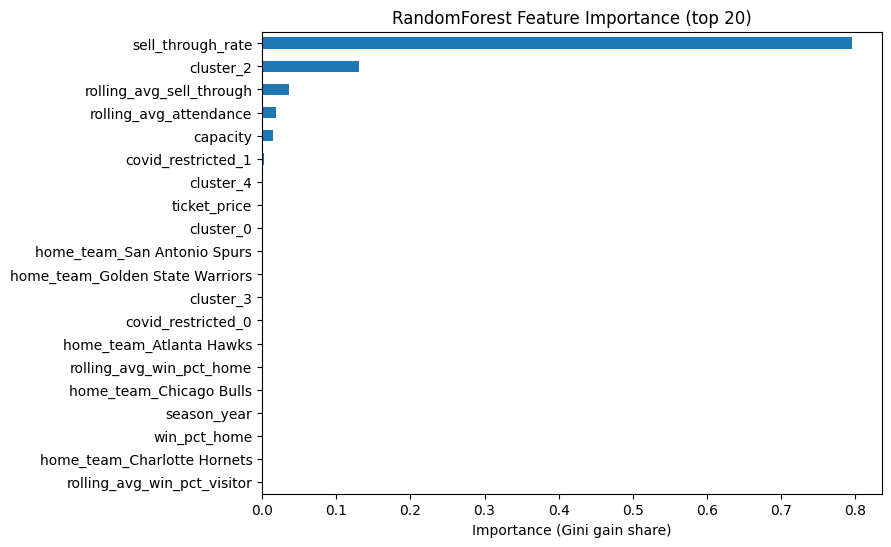

In [50]:
import pandas as pd
# feature_names = model_features.drop(columns=['game_date', 'attendance']).columns
# assert len(feature_names) == rf_best.n_features_in_

fi = (
    pd.Series(rf_best.feature_importances_, index=feature_names)
      .sort_values(ascending=False)
      .head(20)
)

fi.plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title('RandomForest Feature Importance (top 20)')
plt.xlabel('Importance (Gini gain share)')
plt.show()

/Users/karan/Desktop/Learnings/fansight_project/.venv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/Users/karan/Desktop/Learnings/fansight_project/.venv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/karan/Desktop/Learnings/fansight_project/.venv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/karan/Desktop/Learnings/fansight_project/.venv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/karan/Desktop/Learnings/fansight_project/.venv/lib/python3.12/site-packages/sklearn/base.py:465: Use

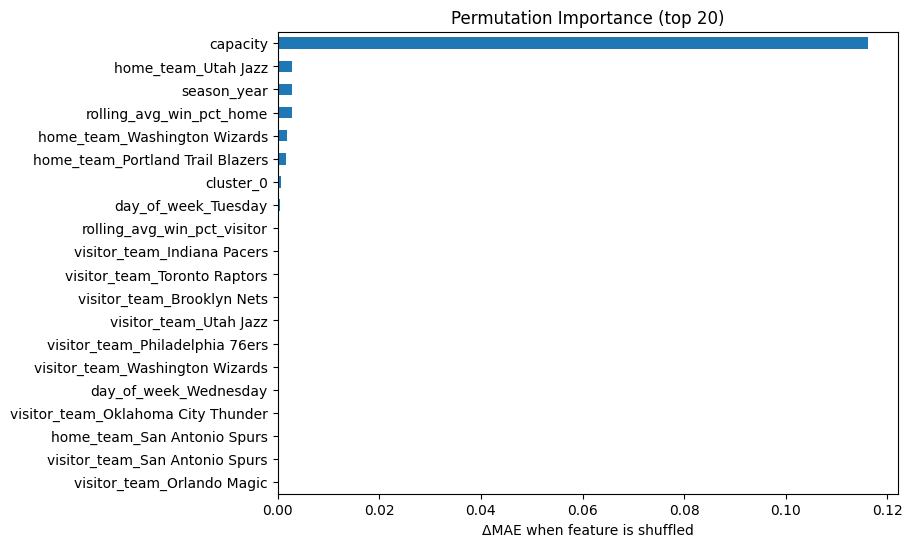

In [51]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf_best,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

perm_importance = (
    pd.Series(perm.importances_mean, index=feature_names)
      .sort_values(ascending=False)
      .head(20)
)

perm_importance.plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title('Permutation Importance (top 20)')
plt.xlabel('ΔMAE when feature is shuffled')
plt.show()


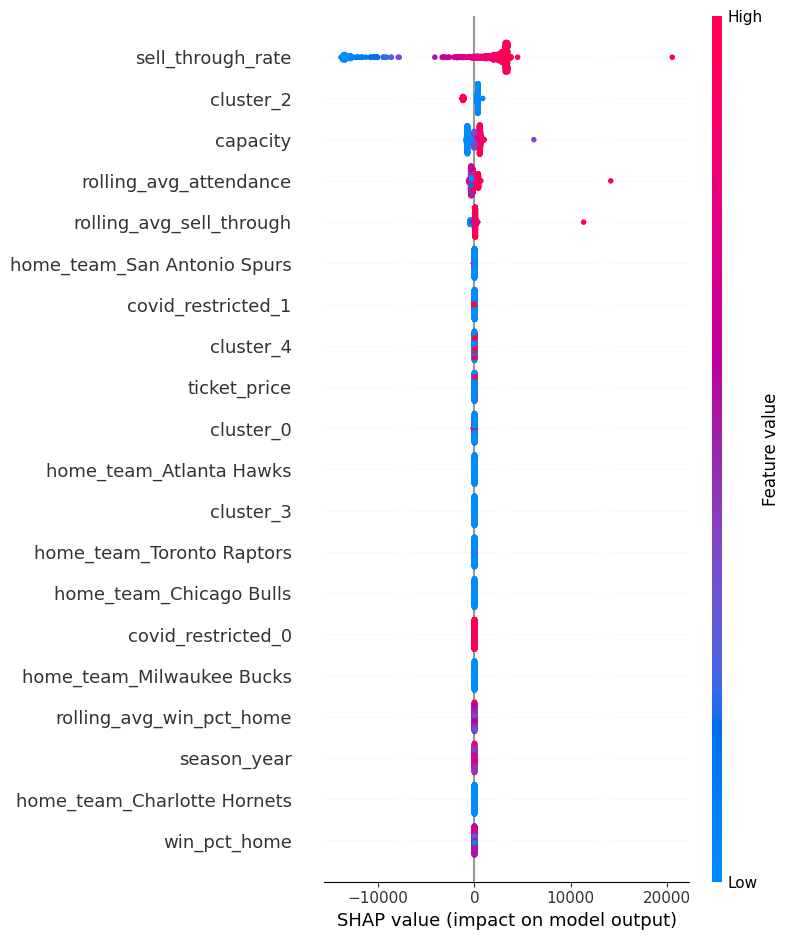

In [52]:
import shap
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_test[:1000])  # subset for speed
shap.summary_plot(shap_values, X_test[:1000], feature_names=feature_names)

### Model Insights

- sell_through_rate (attendance ÷ capacity) is the dominant driver: high sell-through pushes predictions up, low pushes them down.
- Capacity, rolling sell-through/attendance, and covid flags carry the next biggest weight—capturing venue size, momentum, and restrictions.
- Team and day-of-week indicators provide finer adjustments (market-specific demand, weekend vs weekday).
- SHAP and permutation plots confirmed these drivers behave intuitively: covid restrictions lower attendance, high-capacity arenas and high-demand clusters lift it.

The tuned RandomForest (n_estimators=500, max_depth=35, max_features=0.8, min_samples_split=3, min_samples_leaf=1, bootstrap=False) has the best holdout MAE (~30.5) and interpretable behavior, so we move forward with it.